In [72]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size

model_file_name = "ms2deepscore_model.pt"
neg_test_spectra_file_name = "neg_testing_spectra.mgf"
pos_test_spectra_file_name = "pos_testing_spectra.mgf"

download_file("https://zenodo.org/records/14290920/files/settings.json?download=1", "ms2deepscore_settings.json")
download_file("https://zenodo.org/records/14290920/files/ms2deepscore_model.pt?download=1", model_file_name)
download_file("https://zenodo.org/records/13934470/files/negative_testing_spectra.mgf?download=1", neg_test_spectra_file_name)
download_file("https://zenodo.org/records/13934470/files/positive_testing_spectra.mgf?download=1", pos_test_spectra_file_name)

The file ms2deepscore_settings.json already exists, the file won't be downloaded
The file ms2deepscore_model.pt already exists, the file won't be downloaded
The file neg_testing_spectra.mgf already exists, the file won't be downloaded
The file pos_testing_spectra.mgf already exists, the file won't be downloaded


In [2]:
from matchms.importing import load_from_mgf
from tqdm import tqdm
import os

pos_test = list(tqdm(load_from_mgf(pos_test_spectra_file_name)))
neg_test = list(tqdm(load_from_mgf(neg_test_spectra_file_name)))

24911it [00:12, 1960.28it/s]
7142it [00:04, 1778.88it/s]


In [3]:
pos_test_spectra = []
for spectrum in pos_test:
    if spectrum.get("inchikey")[:14] != "FTXGVGWYYREYSV":
        pos_test_spectra.append(spectrum)


### Select one spectrum per inchikey
Since it is computationally not feasible to compute a matrix between 25000* 25000 spectra with a modified cosine score, we instead just select one spectrum per unique molecule.

In [4]:
import random

def select_one_spectrum_per_inchikey(spectra):
    shuffled_spectra = random.sample(spectra, len(spectra))
    selected_spectra = []
    inchikeys = []
    for spectrum in shuffled_spectra:
        inchikey = spectrum.get("inchikey")[:14]
        if inchikey not in inchikeys:
            selected_spectra.append(spectrum)
            inchikeys.append(inchikey)
    return selected_spectra
selected_pos_spectra = select_one_spectrum_per_inchikey(pos_test_spectra)
selected_neg_spectra = select_one_spectrum_per_inchikey(neg_test)

# Reduce to 100 peaks
Also to improve compute time, we reduce the spectra to 100 peaks. By removing the least intense peaks. 

In [10]:
from matchms.filtering import reduce_to_number_of_peaks
selected_pos_spectra_with_max_100_peaks = []
for spectrum in selected_pos_spectra:
    selected_pos_spectra_with_max_100_peaks.append(reduce_to_number_of_peaks(spectrum, n_max=100))

(array([384., 379., 264., 167., 127.,  87.,  56.,  50.,  34., 282.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

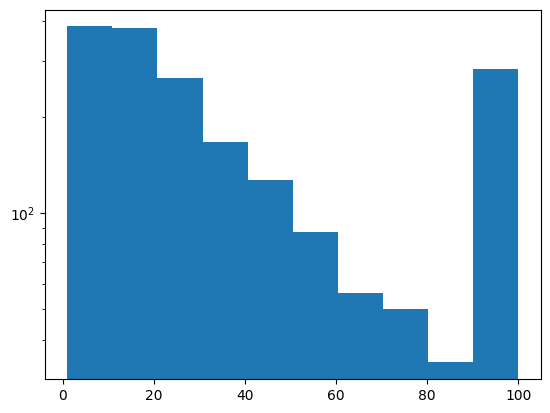

In [11]:
import matplotlib.pyplot as plt
nr_of_peaks = [len(spectrum.mz) for spectrum in selected_pos_spectra_with_max_100_peaks]
plt.hist(nr_of_peaks, log=True)

In [9]:
from matchms.filtering import reduce_to_number_of_peaks
selected_neg_spectra_with_max_100_peaks = []
for spectrum in selected_neg_spectra:
    selected_neg_spectra_with_max_100_peaks.append(reduce_to_number_of_peaks(spectrum, n_max=100))

(array([374., 227., 121.,  63.,  23.,  19.,   4.,   4.,   4.,  85.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

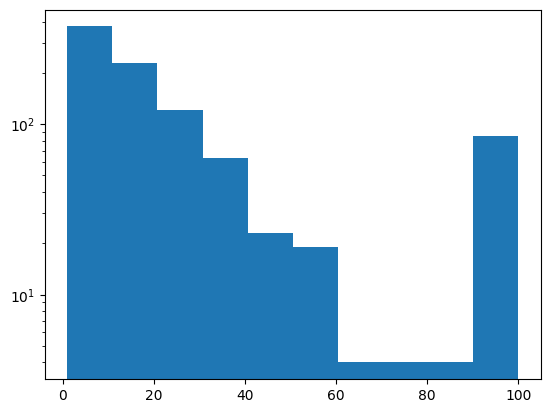

In [12]:
import matplotlib.pyplot as plt
nr_of_peaks = [len(spectrum.mz) for spectrum in selected_neg_spectra_with_max_100_peaks]
plt.hist(nr_of_peaks, log=True)

# Functions for calculating mod cosine and tanimoto score and functions for plotting

In [14]:
from matchms import calculate_scores
from matchms.similarity import ModifiedCosine, PrecursorMzMatch
from time import time
import pandas as pd
def calculate_modified_cosine_score(spectra_1, spectra_2, precursor_mz_tolerance, fragment_tolerance, symmetric):
    scores = calculate_scores(spectra_1, spectra_2,
                             PrecursorMzMatch(tolerance=precursor_mz_tolerance),
                              array_type="sparse",
                              is_symmetric=symmetric)
    print(scores.__repr__())
    start_time = time()
    similarity_measure = ModifiedCosine(tolerance=fragment_tolerance)
    new_scores = similarity_measure.sparse_array(references=spectra_1,
                                                 queries=spectra_2,
                                                 idx_row=scores.scores.row,
                                                 idx_col=scores.scores.col,
                                                 is_symmetric=symmetric)
    scores.scores.add_sparse_data(scores.scores.row,
                                  scores.scores.col,
                                  new_scores,
                                  similarity_measure.__class__.__name__)
    df_with_scores = pd.DataFrame(scores.to_array()["ModifiedCosine_score"], 
             index=[spectrum.get("inchikey")[:14] for spectrum in spectra_1], 
             columns=[spectrum.get("inchikey")[:14] for spectrum in spectra_2])
    print(time() - start_time)
    return df_with_scores


In [15]:
from ms2deepscore.validation_loss_calculation.PredictionsAndTanimotoScores import PredictionsAndTanimotoScores
from ms2deepscore.validation_loss_calculation.calculate_scores_for_validation import create_embedding_matrix_symmetric, \
    create_embedding_matrix_not_symmetric, calculate_tanimoto_scores_unique_inchikey


def get_tanimoto_and_prediction_pairs(spectra_1, spectra_2=None, label="",
                                      fingerprint_type="daylight",
                                      n_bits=4096, precursor_tolerance=100) -> PredictionsAndTanimotoScores:
    symmetric = False
    if spectra_2 is None:
        spectra_2 = spectra_1
        symmetric = True
    predictions_df = calculate_modified_cosine_score(spectra_1, spectra_2, precursor_tolerance, 0.1, symmetric)
    tanimoto_scores_df = calculate_tanimoto_scores_unique_inchikey(spectra_1, spectra_2,
                                                                   fingerprint_type=fingerprint_type, nbits=n_bits)
    return PredictionsAndTanimotoScores(predictions_df, tanimoto_scores_df, symmetric, label)


In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
from ms2deepscore.validation_loss_calculation.PredictionsAndTanimotoScores import PredictionsAndTanimotoScores
from ms2deepscore.benchmarking.plot_heatmaps import convert_dataframes_to_lists_with_matching_pairs
from matplotlib.colors import LogNorm

def create_normalized_heatmap_data(prediction_and_tanimoto_scores,
                                   x_bins, y_bins):
    average_prediction = \
        prediction_and_tanimoto_scores.get_average_prediction_per_inchikey_pair()
    list_of_tanimoto_scores, list_of_average_predictions = convert_dataframes_to_lists_with_matching_pairs(
        prediction_and_tanimoto_scores.tanimoto_df,
        average_prediction)
    heatmap = np.histogram2d(list_of_tanimoto_scores,
                             list_of_average_predictions,
                             bins=(x_bins, y_bins))[0]

    normalized_heatmap = heatmap / heatmap.sum(axis=1, keepdims=True)
    # normalized_heatmap[np.isnan(normalized_heatmap)] = 0.0
    return normalized_heatmap

def create_3_heatmaps(pos_vs_pos_scores,
                      pos_vs_neg_scores,
                      neg_vs_neg_scores, 
                      nr_of_bins, 
                     y_axis_label=""):
    minimum_y_axis = 0
    maximum_y_axis = 1
    for predictions_and_tanimoto_score in (pos_vs_pos_scores,
                pos_vs_neg_scores,
                neg_vs_neg_scores):
        average_pred_per_inchikey_pair = predictions_and_tanimoto_score.get_average_prediction_per_inchikey_pair()
        minimum = average_pred_per_inchikey_pair.min().min()
        maximum = average_pred_per_inchikey_pair.max().max()
        if minimum < minimum_y_axis:
            minimum_y_axis = minimum
        if maximum > maximum_y_axis:
            maximum_y_axis = maximum

    x_bins = np.linspace(0, 1, nr_of_bins + 1)
    y_bins = np.linspace(minimum_y_axis, maximum_y_axis + 0.00001, nr_of_bins + 1)

    # Take the average per bin
    pos_pos_normalized_heatmap = create_normalized_heatmap_data(pos_vs_pos_scores, x_bins, y_bins)
    neg_neg_normalized_heatmap = create_normalized_heatmap_data(neg_vs_neg_scores, x_bins, y_bins)
    pos_neg_normalized_heatmap = create_normalized_heatmap_data(pos_vs_neg_scores, x_bins, y_bins)

    maximum_heatmap_intensity = max(pos_pos_normalized_heatmap.max(), neg_neg_normalized_heatmap.max(),
                                    pos_neg_normalized_heatmap.max())
    cmap = plt.cm.inferno

    cmap.set_bad(color='black')
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(neg_neg_normalized_heatmap.T, origin='lower', interpolation='nearest',
                   cmap=cmap, extent=[0, 1, minimum_y_axis, maximum_y_axis],
                  norm=LogNorm(vmin=1e-2, vmax=1))
    axes[0].set_title("Negative vs negative")
    axes[1].imshow(pos_pos_normalized_heatmap.T, origin='lower', interpolation='nearest',
                   cmap=cmap, extent=[0, 1, minimum_y_axis, maximum_y_axis],
                  norm=LogNorm(vmin=1e-2, vmax=1))
    axes[1].set_title("Positive vs positive")
    im2 = axes[2].imshow(pos_neg_normalized_heatmap.T, origin='lower', interpolation='nearest',
                         cmap=cmap, extent=[0, 1, minimum_y_axis, maximum_y_axis],
                        norm=LogNorm(vmin=1e-2, vmax=1))
    axes[2].set_title("Positive vs negative")
    for ax in axes:
        ax.set_xlabel("True chemical similarity")
        ax.set_ylabel(y_axis_label)
        ax.set_xlim(0, 1)
        ax.set_ylim(minimum_y_axis, maximum_y_axis)

    cbar = fig.colorbar(im2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Density')  # Label for the colorbar
    return fig

# Precursor mass tolerance = no mass tolerance

In [65]:
predictions_and_tanimoto_score_pos_neg = get_tanimoto_and_prediction_pairs(selected_pos_spectra_with_max_100_peaks, 
                                                                           selected_neg_spectra_with_max_100_peaks, 
                                                                           "positive vs negative", precursor_tolerance=100000)


<1830x924x1 stacked sparse array containing scores for ('PrecursorMzMatch',) with 1690920 stored elements in COOrdinate format>
1246.7929093837738


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 381.62it/s]


Calculating tanimoto scores


In [66]:
predictions_and_tanimoto_score_neg_neg = get_tanimoto_and_prediction_pairs(selected_neg_spectra_with_max_100_peaks, None, "negative vs negative", precursor_tolerance=100000)

<924x924x1 stacked sparse array containing scores for ('PrecursorMzMatch',) with 853776 stored elements in COOrdinate format>
653.1483798027039


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 375.45it/s]


Calculating tanimoto scores


In [69]:
predictions_and_tanimoto_score_pos_pos = get_tanimoto_and_prediction_pairs(selected_pos_spectra_with_max_100_peaks, None, "positive vs positive", precursor_tolerance=100000)


<1830x1830x1 stacked sparse array containing scores for ('PrecursorMzMatch',) with 3348900 stored elements in COOrdinate format>
14311.563089847565


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:04<00:00, 387.15it/s]


Calculating tanimoto scores


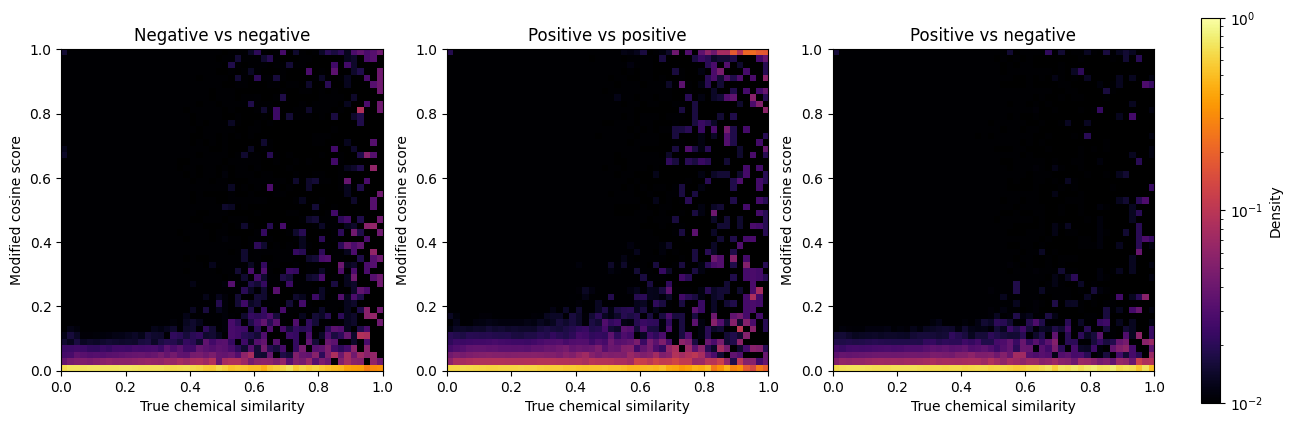

In [77]:
fig=create_3_heatmaps(predictions_and_tanimoto_score_pos_pos, predictions_and_tanimoto_score_pos_neg, predictions_and_tanimoto_score_neg_neg, 50, "Modified cosine score")


In [78]:
fig.savefig("./modified_cosine_figures/modified_cosine_heatmap.svg", bbox_inches='tight')


# Precursor mass tolerance = 100 Da

In [22]:
predictions_and_tanimoto_score_pos_neg_100_Da = get_tanimoto_and_prediction_pairs(selected_pos_spectra_with_max_100_peaks, 
                                                                                  selected_neg_spectra_with_max_100_peaks, 
                                                                                  "positive vs negative")

<1830x924x1 stacked sparse array containing scores for ('PrecursorMzMatch',) with 583458 stored elements in COOrdinate format>
184.88746070861816


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 375.06it/s]


Calculating tanimoto scores


In [38]:
predictions_and_tanimoto_score_pos_pos_100_Da  = get_tanimoto_and_prediction_pairs(selected_pos_spectra_with_max_100_peaks, None, "positive vs positive")

<1830x1830x1 stacked sparse array containing scores for ('PrecursorMzMatch',) with 1244872 stored elements in COOrdinate format>
1977.3697953224182


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:04<00:00, 385.80it/s]


Calculating tanimoto scores


In [17]:
predictions_and_tanimoto_score_neg_neg_100_Da  = get_tanimoto_and_prediction_pairs(selected_neg_spectra_with_max_100_peaks, None, "negative vs negative")

<924x924x1 stacked sparse array containing scores for ('PrecursorMzMatch',) with 282384 stored elements in COOrdinate format>
77.9409327507019


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 366.33it/s]


Calculating tanimoto scores


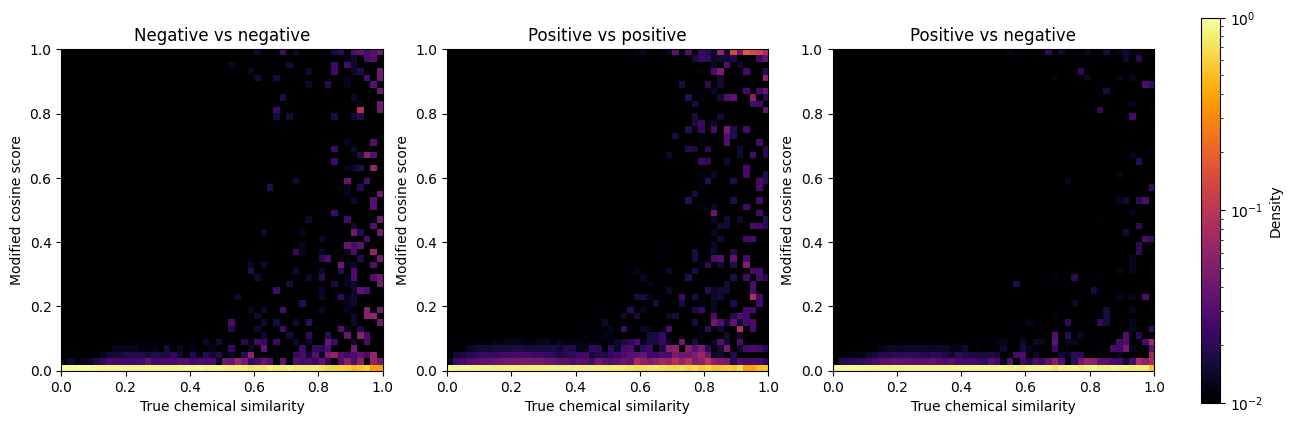

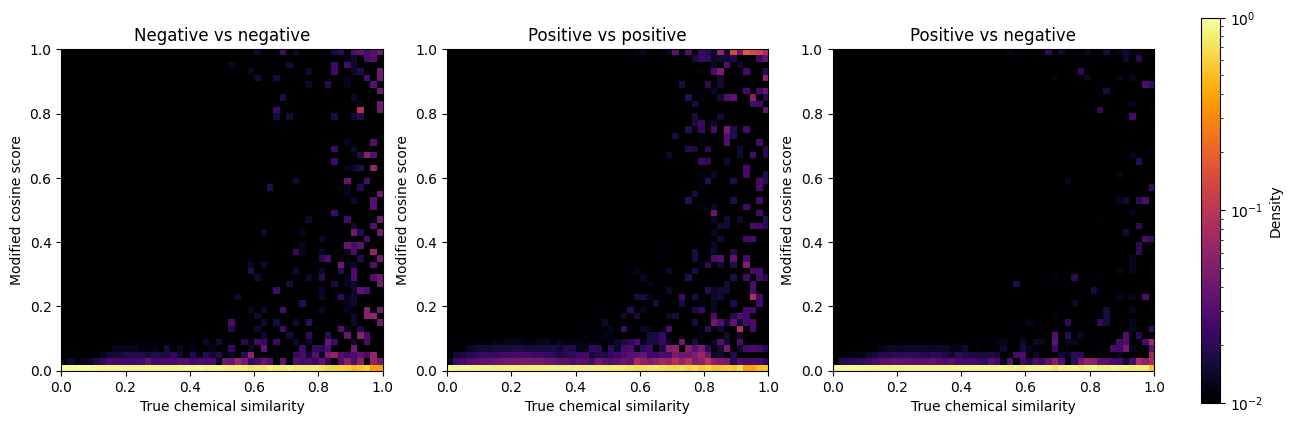

In [63]:
create_3_heatmaps(predictions_and_tanimoto_score_pos_pos_100_Da, predictions_and_tanimoto_score_pos_neg_100_Da, predictions_and_tanimoto_score_neg_neg_100_Da, 50)

Selecting available inchikey pairs per bin: 10it [00:00, 142.17it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 51.18it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 107.38it/s]


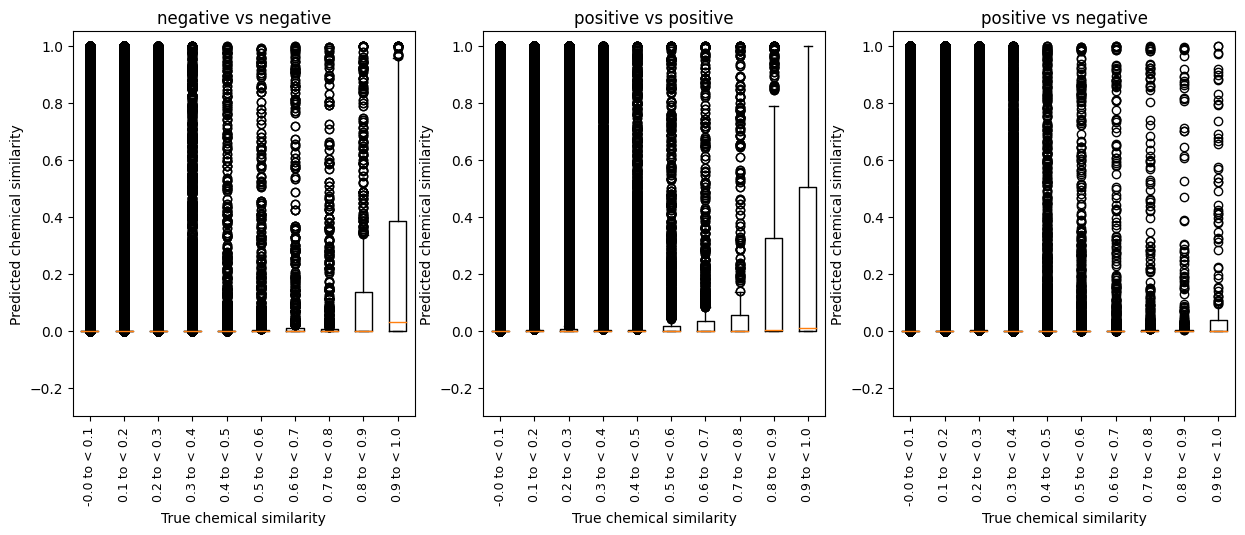

In [43]:
from matplotlib import pyplot as plt

from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
from ms2deepscore.utils import create_evenly_spaced_bins
import pandas as pd

def plot_boxplot_per_bin(pos_vs_pos_scores,
                      pos_vs_neg_scores,
                      neg_vs_neg_scores, nr_of_bins):
    bins = create_evenly_spaced_bins(nr_of_bins)
    bin_centers = [(bin_borders[0] + bin_borders[1])/2 for bin_borders in bins]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))


    for i, predictions_and_tanimoto_scores in enumerate((pos_vs_pos_scores,
                      pos_vs_neg_scores,
                      neg_vs_neg_scores, )):
        average_predictions = predictions_and_tanimoto_scores.get_average_prediction_per_inchikey_pair()
        predictions_per_bin = get_predictions_per_bin(predictions_and_tanimoto_scores, average_predictions, bins)
        axes[i].boxplot(predictions_per_bin, positions=np.arange(len(bins)))

        axes[i].set_xlabel("True chemical similarity")
        axes[i].set_ylabel("Predicted chemical similarity")
        axes[i].set_xticks(np.arange(len(bins)),
               [f"{a:.1f} to < {b:.1f}" for (a, b) in bins], fontsize=9, rotation='vertical')
        axes[i].set_title(predictions_and_tanimoto_scores.label)
        axes[i].set_ylim((-0.3,1.05))
    return fig

def get_predictions_per_bin(predictions_and_tanimoto_scores,
                            average_per_inchikey_pair: pd.DataFrame,
                            tanimoto_bins: np.ndarray):
    """Compute average loss per Tanimoto score bin

    Parameters
    ----------
    average_per_inchikey_pair
        Precalculated average (prediction or loss) per inchikey pair
    ref_score_bins
        Bins for the reference score to evaluate the performance of scores. in the form [(0.0, 0.1), (0.1, 0.2) ...]
    """
    average_predictions = average_per_inchikey_pair.to_numpy()

    sorted_bins = sorted(tanimoto_bins, key=lambda b: b[0])

    bins = [bin_pair[0] for bin_pair in sorted_bins]
    bins.append(sorted_bins[-1][1])

    digitized = np.digitize(predictions_and_tanimoto_scores.tanimoto_df, bins, right=True)
    predictions_per_bin = []
    for i, bin_edges in tqdm(enumerate(sorted_bins), desc="Selecting available inchikey pairs per bin"):
        row_idxs, col_idxs = np.where(digitized == i+ 1)
        predictions_in_this_bin = average_predictions[row_idxs, col_idxs]
        predictions_in_this_bin_not_nan = predictions_in_this_bin[~np.isnan(predictions_in_this_bin)]
        predictions_per_bin.append(predictions_in_this_bin_not_nan)
    return predictions_per_bin
# fig = plot_boxplot_per_bin(predictions_and_tanimoto_score_pos_neg, predictions_and_tanimoto_score_pos_neg, predictions_and_tanimoto_score_neg_neg, 10)
fig = plot_boxplot_per_bin(predictions_and_tanimoto_score_neg_neg_100_Da, predictions_and_tanimoto_score_pos_pos_100_Da,predictions_and_tanimoto_score_pos_neg_100_Da, 10)

# Same plots for ms2deepscore
These are different from the main one in the paper, because we only use one spectrum per inchikey, since it is otherwise computationally unfeasible for mod cos

In [55]:
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
model_file_name = "ms2deepscore_model.pt"
scores_between_ionmodes = CalculateScoresBetweenAllIonmodes(model_file_name, selected_pos_spectra_with_max_100_peaks, selected_neg_spectra_with_max_100_peaks, fingerprint_type="daylight", n_bits_fingerprint=4096)

/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


1830it [00:11, 162.49it/s]
924it [00:01, 717.43it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 368.40it/s]


Calculating tanimoto scores
Calculating embeddings


1830it [00:02, 755.59it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:04<00:00, 381.49it/s]


Calculating tanimoto scores
Calculating embeddings


924it [00:01, 684.61it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 367.61it/s]


Calculating tanimoto scores


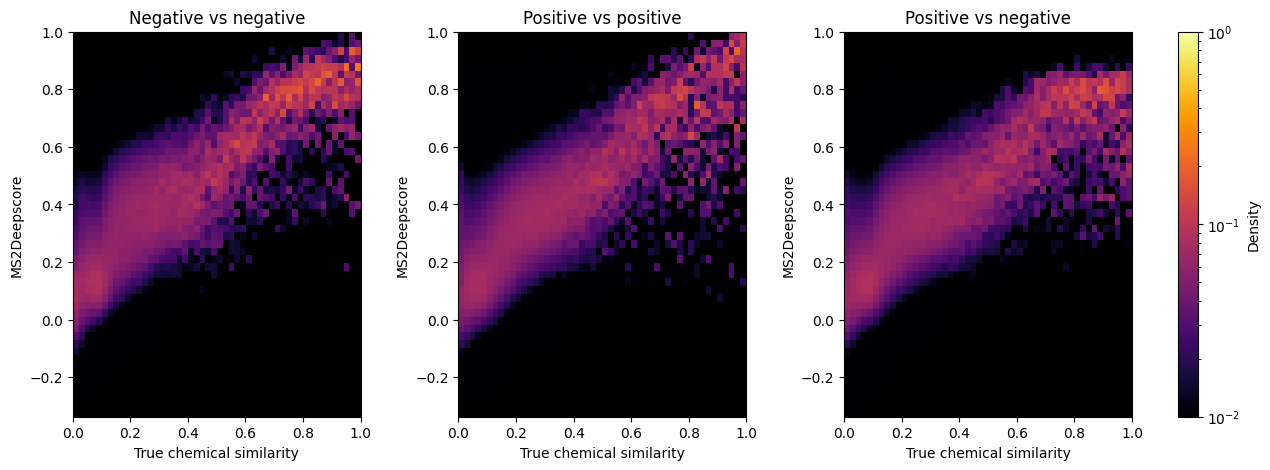

In [80]:
fig = create_3_heatmaps(scores_between_ionmodes.pos_vs_pos_scores, scores_between_ionmodes.pos_vs_neg_scores, scores_between_ionmodes.neg_vs_neg_scores, 50, "MS2Deepscore")
fig.savefig("./modified_cosine_figures/ms2deepscore_heatmap_1_spectrum_per_molecule.svg", bbox_inches='tight')
